# Sequence Comparison with LingPy

This tutorial will run you through the major steps needed in order to infer cognates automatically with [LingPy](http://lingpy.org) ([List and Forkel 2016](:ref:List2016e)) from linguistic word list data and to export the data into various formats so that you can either inspect them using tools like the [EDICTOR](http://edictor.digling.org) ([List 2017](:ref:List2017d)), or further analyse them, using software like [SplitsTree](http://splitstree.org) ([Huson 1998](:ref:Huson1998)) or [BEAST](http://www.beast2.org) ([Bouckaert et al. 2014](:ref:Bouckaert2014)).

Basically, this tutorial assumes that you have at least an undergraduate level understanding of historical linguistics (particularly the comparative method), requiring only working knowledge of Python and command line operation. Commands will be provided in addition to the pure Python examples in form of a Python script which can be triggered by calling it via the command line and passing certain keywords:

```bash
$ python3 autocogs.py help
```

It is required that you have installed both LingPy in the version [2.5.1](https://github.com/lingpy/lingpy/releases/tag/v2.5.1) for Python3 (as this tutorial will assume that you use Python3) available on [GitHub](https://github.com/lingpy/lingpy), and (as a plus) the [python-igraph](http://igraph.org) package ([Csárdi and Nepusz 2006](:ref:Csardi2006)). Furthermore, in order to follow all examples given in this tutorial, it is useful to work with the [ipython](http://ipython.org) suite, which is very convenient for testing code pieces directly against the Python interpreter.

*Tiago - I agree that this document should focus on LingPy's usage, but it is essential to give a detailed guide for installing LingPy. Even if the pip version (including cddlutils) is up to date, running `pip install lingpy` is not something so trivial to someone with the expected knowledge of programming/Python/system administration, especially considering the differences between operating systems. Perhaps even a step-by-step instruction or a virtual machine with everything in place could be considered (I used this years ago, when I taught NLTK). I also believe it is important to state the level of Python knowledge that this tutorial assumes, even if it can be followed by most people without a deep understanding of things such as classes, list comprehensions, etc.*

The tutorial is divided into different blocks, during which different aspects of sequence comparison will be illustrated from the concrete perspective of LingPy. In order to understand fully all that is going on, however, this tutorial won't be sufficient, and it is recommended that those who are interested in the algorithmic and conceptual details of LingPy's major algorithms for sequence comparison have a closer look at the book [Sequence Comparison in Historical Linguistics](https://sequencecomparison.github.io) ([List 2014](:ref:List2014d) in which the most comprehensive state of the art is reflected. More recent papers might occasionally be mentioned in order to account for those aspects of sequence comparison which have been changed since then, but the book on sequence comparison (which is also freely available for download) is still the best starting point.

The tutorial is divided into the following parts:

1. Hands on the Data: Preparing, Loading, and Testing Word List Data
2. Phonetic Alignment
3. Automatic Cognate Detection
4. Further Use: Inspection, Evaluation, and Export


## Hands on the Data

### The Testset

Linguists are often skeptical when they hear that LingPy requires explicit phonetic transcriptions, and often, they are even reluctant to interpret their data along the lines of the International Phonetic Alphabet. But in order to give the algorithms a fair chance to interpret the data in the same way in which they would be interpreted by linguists, a general practice for phonetic transcriptions is indispensable. 

*Tiago - maybe a reference to such skepticism could be given here.*

For our test, we will use a dataset consisting of 31 Polynesian languages taken from the [ABVD](http://language.psy.auckland.ac.nz/austronesian/) ([Greenhill et al. 2008](:ref:Greenhill2008)). This dataset was intensively revised and cleaned in collaboration with Mary Walworth, who corrected many problematic entries and provided detailed information on how to convert the data into standardized phonetic transcriptions. The testset, along with our basic script containing also this tutorial, is available in the [lingpy](+++) folder of the [QMSS-2017](https://github.com/shh-dlce/qmss-2017) repository. In the following, we will assume that you opened the terminal in this folder so that in case you list all files using the `ls` command, you will see files like:

* `autocogs.py`
* `polynesian.tsv`

Let us start by quickly examining the file `polynesian.tsv` which we prepared for this occasion. This file is a tab-separated text file with the first row indicating the header, and the very first column is reserved for numeric identifiers. If you open this file in a spreadsheet editor (and make sure to select "tab" as a delimiter, and NO characters to delimit a cell), will see that it is a very straightforward spreadsheet, in which the first row is a header indicating the names of the columns, and the first cell is reserved for an identifier, which should be numeric (but order does not matter).

ID | DOCULECT | CONCEPT | GLOTTOCODE | CONCEPTICON_ID | VALUE | FORM | TOKENS | VARIANTS | SOURCE | COGID | LOAN
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
188 | Emae_1030 | Eight | emae1237 | 1705 | βaru | βaru | β a r u |  | 52375 | 750 | False
447 | RennellBellona_206 | Eight | renn1242 | 1705 | baŋgu | baŋgu | b a ŋ g u |  | POLLEX | 750 | False
703 | Tuvalu_753 | Eight | tuva1244 | 1705 | valu | valu | v a l u |  | 29903 | 750 | False
927 | Sikaiana_243 | Eight | sika1261 | 1705 | valu | valu | v a l u |  | POLLEX | 750 | False
1135 | Penrhyn_235 | Eight | penr1237 | 1705 | varu | varu | v a r u |  | POLLEX | 750 | False
6114 | Kapingamarangi_217 | Eight | kapi1249 | 1705 | waru | waru | w a r u | walu | POLLEX | 750 | False

You may even prepare your data in a spreadsheet to then analyze it in LingPy. You just need to make sure to export it properly to the TSV format (which you can easily do by just copy-pasting it into an empty text-file). What you need to know about the format, however, is the following:

1. contrary to most linguists' intuition, the columns do **not** indicate languages: each row indicates one word and, as a result, language names need to be redundantly repeated
2. certain columns are **required** by LingPy, and their number can vary, depending on the task you want to carry out: for the purpose of cognate detection, you need at least the columns `doculect`, `concept`, and either a plain transcription (the default column name is `ipa`) or a more advanced and less ambiguous transcription in segmented form (the default column name is `tokens`).
3. in order to increase readability, column headers are upper-case when LingPy writes them to file, but this is not required (internally all columns are represented as lowercase when loaded into LingPy's objects)
4. depending on the names of the columns, values will be interpreted by default: if you have a column called `cogid`, this will be converted to an integer, and `tokens` usually assumes that you have a string separated by spaces. As a result, LingPy may throw an error if your columns do not follow these required formats. To check how columns are interpreted, you can check the file [wordlist.rc](https://github.com/lingpy/lingpy/blob/master/lingpy/data/conf/wordlist.rc) where you will find a full account of currently supported values.

Not all of the columns in the table above are fully "standardized". The `DOCULECT` one, for example, so far only requires that distinct languages are given distinct names, no matter what those names contain (as long it has no tabulation stops). But for the purpose of exporting the data to other formats afterward, it is useful to restrict to alphanumeric names here, and to exclude all brackets or spaces from the language names, as we have been doing in this test set. This becomes especially important when inferring trees or using trees in further LingPy analyses: as trees are represented in the [Newick](https://en.wikipedia.org/wiki/Newick_format) format, where brackets play an important role, brackets in the names for the doculects will confuse the algorithm and raise an error.

*Tiago - Considering that the paragraph below explains where the GLOTTOCODE and CONCEPTICON_ID come from, it might be worth explaining where the DOCULECT ids for this example come from, too.*

As the last point, note that we list `GLOTTOCODE` and `CONCEPTICON_ID`, which follows two major requirements for word list data we try to establish for the [Cross-Linguistic Data Formats (CLDF)](http://cldf.clld.org) initiative. As the linguistic sign has three major dimensions, the *language*, the *meaning*, and the *word form*, `GLOTTOCODE`, the language identifier provided by the [Glottolog project](http://glottolog.org) ([Hammarström, Forkel and Haspelmath 2017](:ref:Hammarstroem2017)) and `CONCEPTICON_ID`, the meaning identifier provided by the [Concepticon project](http://concepticon.clld.org) ([List, Cysouw, and Forkel 2016](:ref:List2016a) cover two of these aspects, while the third aspect, the consistency of the form, is currently covered by LingPy (more on this below).

### Segmentation of Phonetic Entries

In addition to the "normal" requirement of the data to be written in IPA, LingPy offers to provide the explicit segmentation of the data into sound segments. Segmentation is represented as a space-separated string in the input data, as you can see when looking at the table above, right in the cells of the `TOKENS` column. While segmentation looks unspectacular in these cases where each sound is represented by only one symbol, it may become problematic when dealing with affricates, pre-aspirated sounds, and complex vowels. The problem is usually that IPA transcriptions are inherently ambiguous, and this ambiguity is then passed on to the algorithms which cannot handle it. For example, a word like German `[`apfəl`]` "apple" could be either segmented as `[` a p f ə l `]`, or, and historically more consistently, as `[` a pf ə l `]`. But if the latter reading is intended (and this is usually language-family-specific), the only way to handle this consistently in IPA would be to put the bar over it: `[`ap͡fəl`]`. This practice, however, would still render the detection of pre-aspiration and other cases impossible. Although LingPy deals rather well with explicit IPA, we recommend all users to segment the data themselves and indicate this by placing one column in their input word list, in which the phonetic entries are explicitly segmented by a space (with the underscore being used to mark original spaces, i.e., word breaks).

LingPy's `sequence`-package offers many functions to handle phonetic sequences and to segment them automatically. As an example, consider the following code-pieces and try to find out what they are actually doing (or trigger ```$ python3 autocog.py segments``` in the command line):

In [1]:
from __future__ import unicode_literals, print_function, division
from lingpy import *

seq1, seq2, seq3, seq4, seq5 = "th o x t a", "thoxta", "apfəl", "tʰoxtɐ", "dɔːtər"

print(seq1, "\t->\t", '\t'.join(ipa2tokens(seq1)))
print(seq2, "  \t->\t", '\t'.join(ipa2tokens(seq2)))
print(seq2, "  \t->\t", '\t'.join(ipa2tokens(seq2, semi_diacritics="h")))
print(seq3, "  \t->\t", '\t'.join(ipa2tokens(seq3)))
print(seq3, "  \t->\t", '\t'.join(ipa2tokens(seq3, semi_diacritics="f")))
print(seq4, "  \t->\t", '\t'.join(ipa2tokens(seq4)))
print(seq5, "  \t->\t", '\t'.join(ipa2tokens(seq5)))

th o x t a 	->	 th	o	x	t	a
thoxta   	->	 t	h	o	x	t	a
thoxta   	->	 th	o	x	t	a
apfəl   	->	 a	p	f	ə	l
apfəl   	->	 a	pf	ə	l
tʰoxtɐ   	->	 tʰ	o	x	t	ɐ
dɔːtər   	->	 d	ɔː	t	ə	r


You can see from these examples that LingPy's `ipa2tokens` function automatically identifies diacritics and the like, but that you can also tweak it to some extent. If the sequence contains white spaces, as in the first example, `ipa2tokens` will split by white space and assume that the data is *already* segmented. We won't go into the details of this and other functions here, but you should consider giving the documentation a proper read before you start spending time on segmenting your data manually. At the same time, when trusting LingPy's default algorithm for segmentation, you should always make sure after using it that the segmentations make sense. If they are largely wrong or problematic, you should refine them before running any automatic cognate detection method.

An alternative is to use the `segments` package by Steven Moran, whose main idea is more comprehensively described in [Moran and Cysouw (2017)](:ref:Moran2017). We have in fact been using it for our working example in order to segment the ABVD data on Polynesian languages properly, but it would require more time to introduce you to all the details at this point. Just keep in mind that segmentation is **crucial** for automatic cognate detection and that it is your responsibility to make sure that the algorithms "understand" the data you give them to analyze.

Above, I wrote that LingPy takes care of the *word form* as one of the units of the linguistic sign in the classical "Saussurean" model. But how can we know whether LingPy recognizes a symbol or not? For this, we need to understand what LingPy does internally with word forms. Here, LingPy follows [Dolgopolsky's (1964)](:ref:Dolgopolsky1964) idea of "sound classes", namely the idea that we can break down the complexity inherent in phonetic transcription to some major classes of sounds so that those sounds represent some kind of a coherent unit. Dolgopolsky was thinking of sounds which often occur in correspondence relation to each other, assuming that there is a certain sound-correspondence probability inherent in all sounds (see also [Brown, Holman, and Wichmann 2013](:ref:Brown2013)). In my experience so far, this is definitely one important aspect, but even more important is the role of reducing variation which is unnecessary for historical comparison while at the same time maintaining a sufficient degree of distinctiveness. For this reason, I expanded Dolgopolsky's original system of only 10 sound classes to as many as 25 sound classes, and LingPy further offers the alphabet which was used for the [ASJP project](http://asjp.org) ([Wichmann, Holman, and Brown 2014](Wichmann2014)), which consists of 40 symbols in a slightly modified version. The following image illustrates the differences between these sound class alphabets and also shows how they represent the Greek word for "daughter".

![image](soundclasses.jpg)

How can we represent sound classes in LingPy? There is one main function that converts a segmented sound sequence into sound classes. This function `tokens2class` takes as input a list or a tuple of segments, that is, the output which you would also get when calling `ipa2tokens`, and a valid sound class model. You can theoretically create models yourself, and pass them as an instance of a specific `Model` class in LingPy, but for the moment, we will only use the ones which are there and denote them with strings, i.e., `dolgo` for Dolgopolsky's model, `sca` for my expanded model of Dolgopolsky, and `asjp` for the ASJP model). Let's just take these three and another specific model, called `art` (for "articulation") which gives numbers to indicate the prosody of sounds, and convert the word Greek `[`θiɣatɛra`]` into the different sound class systems (you can also trigger this by typing ```$ python3 autocogs.py classes``` in the command line).


In [2]:
word = "θiɣatɛra"
segs = ipa2tokens(word)

# iterate over sound class models and write them in converted version 
for model in ['dolgo', 'sca', 'asjp', 'art']:
    print(word, ' -> ', ''.join(tokens2class(segs, model)), '({0})'.format(model))

θiɣatɛra  ->  TVKVTVRV (dolgo)
θiɣatɛra  ->  DIGATERA (sca)
θiɣatɛra  ->  8ixatEra (asjp)
θiɣatɛra  ->  37371757 (art)


Note that the conversion to sound classes is the major check whether LingPy has "understood" your input. If LingPy does not find a class symbol corresponding to a given segment, it will use the default character "0" to indicate this failure of converting a given sound sequence. This zero will be treated as an uninvited guest in most comparisons. It won't be aligned with other elements and will score negatively in the automatic cognate detection routines. You should thus try to avoid this by making sure that your sequences do not contain any errors. When carrying out cognate the detection analysis, we have a specific keyword `check` which you can set to `True` to make sure that all sequences with zeros in sound classes are excluded before the analysis is carried out. But you can easily write a Python function to check yourself in only a few lines (write ```$ python3 autocogs.py errors``` in command line):

In [3]:
from collections import defaultdict

def check_sequence(seq):
    """Takes a segmented string as input and returns erroneously converted segments."""
    cls = tokens2class(seq, 'dolgo') # doesn't matter which model to take, all cover the same character range
    errors = defaultdict(int)
    for t, c in zip(seq, cls):
        if c == '0':
            errors[t] += 1
    return errors

word = "θiɣatEra"
seq = ipa2tokens(word)
for error, count in check_sequence(seq).items():
    print("The symbol <{0}> occurs {1} times and is not recognized.".format(error, count))

The symbol <E> occurs 1 times and is not recognized.


### Loading the Data into a `Wordlist` Object

Loading the data into LingPy is straightforward. LingPy has a couple of classes which are specifically designed to handle word list data, and these classes provide all similar basic functions, plus additional ones for specific purposes:

* `Wordlist`: Basic class with core functionality, allows to read, modify, and write word list data, also allows  calculating distance matrices from cognate sets as well as rudimentary tree reconstruction functions (UPGMA, [Sokal and Michener 1958](:ref:Sokal1958), Neighbor-joining, [Saitou and Nei 1987](:ref:Saitou1987)).
* `Alignments`: Class allows to align all cognate sets in a word list. Requires one column which stores the cognate sets as well as a column for `doculect`, `concept`, and transcription (default: `ipa`) or user-defined *segmented transcription* (default: `tokens`). Alignments can be carried out in different ways, the algorithms follow the ones first described in [List (2012a)](:ref:List2012b).
* `LexStat`: Core class for automatic cognate detection, following the algorithm first described in [List (2012b)](:ref:List2012a) and later expanded in [List (2014)](:ref:List2014d), and [List, Greenhill, and Gray (2017)](List2017c). 
* `Partial`: Recent algorithm proposed in [List, Lopez, and Bapteste (2016)](:ref:List2016g), allows -- provided data is morpheme-segmented -- to search for partial cognates in the data.

We will start with the basic `Wordlist` object to illustrate some core facilities below (command line: ```$ python3 autocogs.py wordlist1```).

In [4]:
# load the wordlist
wl = Wordlist('polynesian.tsv')

# count number of languages, number of rows, number of concepts
print("Wordlist has {0} languages and {1} concepts across {2} rows.".format(wl.width, wl.height, len(wl)))

Wordlist has 31 languages and 210 concepts across 7551 rows.


By accessing the attributes `width` we retrieve the number of languages and with `height` we retrieve the number of concepts. This follows the logic inherent in the traditional format in which linguists prepare their spreadsheets, namely by placing concepts in the first column and languages in the rest of the columns. Traditional linguistic databases would thus represent the data from the table above as follows:

CONCEPT | Emae_1030 | RennellBellona_206 | Tuvalu_753 | Sikaiana_243 | Penrhyn_235 | Kapingamarangi_217 
--- | --- | --- | --- | --- | --- | ---
one | tasi| tahi | tahi | tasi | tahi | dahi
five | rima | gima | lima | lima | rima | lima
eight | βaru | baŋu | valu | valu | varu | waru
... | ... | ... | ... | ... | ... | ...

The disadvantage of this annotation is, however, that we can only store one value in each cell, and we will create inconsistencies if we try to mix information per cell. For that reason, we maintain the strict tabular representation where each word is placed in one row, but internally, LingPy represents the data in multidimensional tables in which languages are thought to be placed in the columns and concepts in the rows. 

There are multiple ways in LingPy to inspect and manipulate data using the `Wordlist` class, but it would go too far to mention them all here, so we will restrict it to one example, by which we retrieve the values from the six languages above for the entry "Eight", using the `wordlist.get_dict()` function, and refer the users to a longer tutorial which is [online](http://lingpy.org/tutorial/lingpy.basic.wordlist.html).


In [5]:
# get all indices for concept "eight", `row` refers to the concepts here, while `col` refers to languages
eight = wl.get_dict(row='Eight', entry='value')
for taxon in ['Emae_1030', 'RennellBellona_206', 'Tuvalu_753', 'Sikaiana_243', 'Penrhyn_235',  'Kapingamarangi_217']:
    print('{0:20}'.format(taxon), '  \t', ', '.join(eight[taxon]))

Emae_1030              	 βaru
RennellBellona_206     	 baŋgu
Tuvalu_753             	 valu
Sikaiana_243           	 valu
Penrhyn_235            	 varu
Kapingamarangi_217     	 walu



### Checking Coverage

For cognate detection, it is not only important to have good phonetic transcriptions (ideally segmented in such a form that they were checked by an experienced linguist), but also to make sure that there are **enough words** in your data. If the data is too sparse, even human linguists would not be able to find any signal based on regular sound correspondences, provided they see the languages the first time and don't know their history (which is the situation for every algorithm). Following an earlier study by [List (2014b)](:ref:List2014c), we know now that at least 100 word pairs for languages as disparate as English and French are needed to provide a solid basis for automatic cognate detection. But when dealing with a large dataset of different languages, which necessarily contains a number of gaps (not all concepts can be elicited in the sources, field work has not provided enough details, etc.), it can be deleterious if the *mutual coverage* between the languages is low. 

By mutual coverage, I mean the number of comparable word pairs (with the same concept) for each language pair in a given dataset. We can compare different aspects of mutual coverage, such as the *average mutual coverage*, where we average the number of available word pairs, or the *minimal mutual coverage*, which provides the smallest mutual coverage of any pair of languages. In addition, one can also ask for the subset fulfilling a minimal mutual coverage for all language pairs, and this task would return the subset of languages in a `Wordlist` which all have at least the mutual coverage specified by the user. LingPy offers now (in version 2.5.1) solutions for all these problems, but since the last problem is considerably hard and computationally intensive, we won't discuss it here, but will instead simply check the minimal mutual coverage which holds for all languages in our sample. So we try to find the lower bound of concept pairs which all languages have in common (type ```$ python3 autocogs.py coverage1``` in command line).

In [6]:
from lingpy.compare.util import mutual_coverage_check, mutual_coverage_subset
for i in range(210, 0, -1):
    if mutual_coverage_check(wl, i):
        print("Minimal mutual coverage is at {0} concept pairs.".format(i))
        break

Minimal mutual coverage is at 162 concept pairs.


This value is definitely good enough for our purpose, given the rule of thumb which says that below a minimal mutual coverage of 100 one should not do language-specific cognate detection analyses. If the coverage is lower, this does not mean you need to give up automatic cognate detection, but it means you should not use the language-specific `LexStat` method but rather a language-independent method, which does not require the information on potential sound correspondences (but will also tend to identify more false positives).

Although, as I just said, the value is good enough, we should further reduce the data a bit to make sure we can inspect them better later on (otherwise, the analyses may also take a lot of time if you run them on computers with insufficient power). So what we will do right now is testing the `mutual_coverage_subset` method which returns a subset of languages for which a given minimal mutual coverage holds. We will then export our `Wordlist` object to file by specifying these languages as our subset (type ```$ python3 autocogs.py coverage2``` in command line):

In [7]:
count, results = mutual_coverage_subset(wl, 200)
coverage, languages = results[0]
print('Found {0} languages with an average mutual coverage of {1}.'.format(count, coverage))

# write word list to file
wl.output("tsv", filename="polynesian-small", subset=True, rows=dict(doculect = "in "+str(languages)))

# load the smaller word list
wl = Wordlist('polynesian-small.tsv')

# print basic characteristics
print("The new word list has {0} languages and {1} concepts across {2} words.".format(
    wl.width, wl.height, len(wl)))

2017-09-04 15:04:28,530 [INFO] Data has been written to file <polynesian-small.tsv>.


Found 14 languages with an average mutual coverage of 207.
The new word list has 14 languages and 210 concepts across 3671 words.


We could not further work with this selection of languages with a very high coverage, and it is always recommended to do so when working on diverse languages samples. For our further tests, however, we will restrict our selection of languages to another subset, namely the East Polynesian languages. Let us now extract those languages from the data (based on their language names) and then see how good the coverage is for this subset.

In [8]:
eastern = ['NorthMarquesan_38', 'Austral_128', 'Austral_1213', 
            'Tahitian_173', 'Sikaiana_243', 'Maori_85', 'Hawaiian_52',
            'Mangareva_239', 'Tuamotuan_246', 'Rapanui_264'] 
wl = Wordlist('polynesian.tsv')
wl.output('tsv', filename='east-polynesian', subset=True,
            rows=dict(doculect = 'in '+str(eastern)))

wl = Wordlist('east-polynesian.tsv')
print("East Polynesian data covers {0} concepts and {1} languages.".format(wl.height, wl.width))

2017-09-04 15:04:30,027 [INFO] Data has been written to file <east-polynesian.tsv>.


East Polynesian data covers 210 concepts and 10 languages.


Let us now repeat the coverage experiment from above, but this time with the Eastern Polynesian language data.

In [9]:
for i in range(210, 0, -1):
    if mutual_coverage_check(wl, i):
        print("Minimal mutual coverage is at {0} concept pairs.".format(i))
        break

Minimal mutual coverage is at 179 concept pairs.


Note that this coverage is much less than the coverage we encountered above. Nevertheless, for our purpose it will be good enough, and the rule of thumb for closely related languages, which says, that we need more than 150 concepts mutually shared between each language pair holds.

## Phonetic Alignment

Phonetic alignment is *per se* independent of the existence of any word list data. Instead, it is a way to align phonetic sequences (words in phonetic transcription) in various ways. Phonetic alignment is an important pre-requisite in order to identify regular sound correspondences. Regular sound correspondences again are important to identify cognates (at least in the classical framework of the comparative method). In addition, alignment analyses are useful in presenting one's analyses in a transparent way, since, unfortunately, scholar often think that their cognate judgments are self-evident, ignoring that a linguist with another language family as their specialty will barely be able to follow the idiosyncratic discourse on language-family-specific sound change patterns and the like. 

In order to carry out alignment analyses in LingPy, you have a range of different possibilities, and there won't be the time to cover all of them here. Instead, I will illustrate how you can make a quick multiple alignment using the `Multiple` class of LingPy. This class is automatically imported when importing LingPy, and it requires a list of sequences as input. Here again, LingPy will automatically try to split your input sequences if they are not already segmentized, but we advise you to segmentize them properly before. Let's just use the six words for "Eight" which we tested before, to align the words accordingly. We type them in by pre-segmenting them, following the space-segmented annotation principle, which is used in all sequence representations of LingPy. We start with the simplest method, the *progressive alignment*, which first makes a little tree of the input sequences and then aligns them by going the tree from the leaves to the root, every time aligning two more until all are aligned (```$ python3 autocogs.py alignments1``` in command line):

In [10]:
msa = Multiple(['β a r u', 'v a ŋ g u', 'v a l u', 'v a l u', 'v a r u', 'w a l u'])
print(msa.align('progressive'))

β	a	-	r	u
v	a	ŋ	g	u
v	a	-	l	u
v	a	-	l	u
v	a	-	r	u
w	a	-	l	u


There are more complicated algorithms available, for example, library-based alignment, following the T-Coffee algorithm ([Notredame et al. 2000](:ref:Notredame2000), based on a so-called "library" which is created before the tree is built. This algorithm, you can use like this (```$ python3 autocogs.py alignments2``` in command line):

In [11]:
print(msa.align('library'))

β	a	-	r	u
v	a	ŋ	g	u
v	a	-	l	u
v	a	-	l	u
v	a	-	r	u
w	a	-	l	u


The results are still the same, but it was shown in [List (2014)](:ref:List2014d) that this algorithm largely enhances more complex alignments.

Last not least, let us quickly check a feature that checks for metathesis in multiple alignments. While metathesis in pairwise alignments has long since been handled, but not in multiple alignments. For this, we need a different set of words, and we take some Slavic words for "apple", where we know that metathesis occurred (```$ python3 autocogs.py alignments3``` in command line):

In [12]:
words = ['j a b l o k o', 'j a b ə l k o', 'j a b l k o', 'j a p k o']
msa = Multiple(words)
print(msa.align('progressive'))
print('There is {0} swap in the alignment.'.format('no' if not msa.swap_check(swap_penalty=-1) else 'a'))

j	a	b	-	l	o	k	o
j	a	b	ə	l	-	k	o
j	a	b	-	l	-	k	o
j	a	p	-	-	-	k	o
There is a swap in the alignment.


Unfortunately, we do not have enough time to go into all the details of alignment analyses, and especially more complex aspects of different alignment modes (*global*, *local*, *semi-global*, etc.), different basic algorithms (extended algorithm for *secondary alignments*), but also how sound classes, the internal representation format in LingPy are integrated into the algorithms, cannot be treated here in full. I can only refer the interested users to both the extensive online documentation at [lingpy.org](http://lingpy.org), as well as my aforementioned [book on sequence comparison](http://sequencecomparison.github.io).




## Cognate Detection

### Checking the Data

I assume that you have thoroughly checked your data manually before running cognate detection analyses. I also assume that you do not have any of the following problems in your data:

* an extensive number of synonyms in one language
* multiple variant forms for the same word form
* data merged from different sources without adjusting the phonetic transcription
* mutual coverage below 100 words per language pair

Before running the cognate detection analysis, you may, however, still want to check whether LingPy recognizes all your data correctly. Here, a very simple way to achieve this is to load the `LexStat` class with the specific keyword `check` set to `True`:

In [13]:
lex = LexStat('east-polynesian.tsv', check=True, segments='tokens')

2017-09-04 15:04:31,010 [INFO] No obvious errors found in the data.


If you have problems in your data encoding, you will be asked if you want to exclude the sequences automatically. As a result, a logfile, called `errors.log` will be created and point you to all erroneous sequences which contain segments which LingPy does not recognize. Let us quickly introduce some bad sequences by just converting randomly all `[`e`]` sounds to the letter A (capitals are never accepted in the normal sound class models of LingPy) and see what we get then. For this, we even do not need to re-write the data, we just add another row where we change the content, give it a random name (we call it "tokens", as this also signals LingPy that the input should be treated as a sequence and not as a string), and specify this for the `LexStat` instance method as the column in the file where the `segments` are. We first load the data as `Wordlist` and then pass that data directly to `LexStat` (```$ python3 autocogs.py trigger-errors``` in command line):

In [14]:
wl = Wordlist('east-polynesian.tsv')

# add new column "segments" and replace data from column "tokens"
wl.add_entries('segments', 'tokens', lambda x: ['A' if y == 'e' else y for y in x])

lex = LexStat(wl, segments='segments', check=True)

2017-09-04 15:04:31,553 [INFO] Data has been written to file <errors.log>.


There were errors in the input data - exclude them? [y/N] 


If you now check the file `errors.log`, you will find a long file with the following first ten lines:

```text
ID	Tokens	Error-Type
1572	<bad character in tokens at «A»>	g a t o a A l i m a
3320	<bad character in tokens at «A»>	p a A _ ʔ a ʔ u r u
5145	<bad character in tokens at «A»>	l i m a s A f u l u
5696	<bad character in tokens at «A»>	r i m a _ t A k a u
12	<bad character in tokens at «A»>	p a A
3327	<bad character in tokens at «A»>	p a A
5153	<bad character in tokens at «A»>	A _ f aː
```

Each row starts with the ID of the word which is contaminated (and this links to the row-ID of your input file), it is followed by a description of the error-type, and then by a segmented form of the word form. LingPy then also creates a file called `lingpy-DATE-cleaned.tsv` (`DATE` meaning the date of the day you run LingPy), in which all contaminated words have been excluded, and this file is read in again, if you pressed "y", and will be the one to run the analysis. 

LingPy thus tries to make the enterprise of cognate detection quite convenient for you as a user, but you should be warned not to use files containing errors for publications, but only for personal test purposes, in order to improve your data. If LingPy does not recognize characters, you should not globally exclude them as a reaction, but should instead try to improve your data until it is publication-ready. Otherwise, the results will much likely be disappointing anyway.


### Overview on Algorithms

LingPy comes along with four pre-defined cognate detection algorithms. These algorithms are all contained in the `LexStat` class which often confuses users, as one of the algorithms provided by `LexStat` is also called `lexstat`. Internally, however, it makes sense, as all algorithms were created at the same time, when I published the LexStat algorithm ([List 2012b](:ref:List2012a)), so I would write it into one class which I called "LexStat" and for the paper, I then also decided to call the algorithm "LexStat" since I could not think of a better name.

*Tiago - I must admit that the fact the both the class and the algorithm are called `lexstat` confused me once, too. There is a lot of compatibility in place, but maybe there should be a wrapper or an alias to one of them? Your surname might not be the best alternative (`list`), but an alias as `jmlist` should be enough. You could also base the name in a description of its difference, such as in the pairwise comparisons, permutations, or in the difference between attested and expected frequencies.*

Anyway, when carrying out cognate detection algorithms, it is important to keep in mind what these algorithms are based on. We can distinguish the following three major types:

1. consonant-class-matching (CCM), following Dolgopolky's (1964) early idea to assume that words with two matching consonant classes would likely be cognate,
2. phenotypic sequence similarity partitioning (PSSP), follows the general idea also applied in homology detection in biology, by which sequences are clustered into sets of homologs based on a partitioning algorithm which is applied to a distance or a similarity matrix representing the overall sequence similarity,
3. language-specific sequence similarity partitioning (LSSP), follows the core idea of the LexStat algorithm by which sequence similarity is calculated on a language-specific basis for each language pair in the data, based on permutation statistics which give hints regarding the most likely candidates for regular sound correspondences.


In LingPy, the methods which you can use to carry out these analyses have specific names, as well as the default output, a cluster decision represented as an integer identifier that assigns words to clusters. They are given in the table below:

Class | Alignments? | Sound Classes? | Sound Correspondences? | Threshold?| LingPy-Name | LingPy-Output | Note
--- | --- | --- | --- | --- | ---
CCM | no | yes | no | no | "turchin" | "turchinid" | Consonant-class matching method close to the description in [Turchin et al. (2010)](:ref:Turchin2010))
PSSP | yes | no | no | yes | "edit-dist" | "editid" | Vanilla edit-distance ([Levenshtein 1965](:ref:Levenshtein1965)), normalized by dividing with the longer string.
PSSP | yes | yes | no | yes | "sca" | "scaid" | Distance score derived from SCA alignments ([List 2012a](:ref:List2012b)) by applying [Downey et al.'s (2008)](:ref:Downey2008) formula
LSSP | yes | yes | yes | yes | "lexstat" | "lexstatid" | The core "LexStat" algorithm described in List ([2012b](:ref:List2012a) and [2014](:ref:List2014d))

As a general rule, you should keep the following in mind (see also our experience with these methods in [List, Greenhill, and Gray (2017)](:ref:List2017c):

1. if you want a fast first analysis and speed counts, take "turchin" (Dolgopolsky method), since it has a low amount of false positives, but it will also miss many cognates
2. if speed does not matter and you have enough concepts (> 100) in your data, and you want to have the most reliable analysis, take "lexstat"
3. if you have less than 100 concepts, and speed does not really matter, take "sca", as it yields consistently better results as the "turchin" method

### Running the Analysis

Let us now, before we sink too much into the details, just start and do all four analyses on our `mikronesian.tsv` test data. Note that due to the permutation approach used by the "lexstat" method, we will need to write two commands here, while we need only one command for the other three methods. We start by loading the data into the `LexStat` class and will then run the "turchin" analyses for the start, and we then print out the results for the item "Eight" (```$ python3 autocogs.py cognates-turchin``` in command line):

In [15]:
lex = LexStat('east-polynesian.tsv', segments='tokens', check=True)

# run the dolgopolsky (turchin) analysis, which is threshold-free
lex.cluster(method='turchin')

# show the cognate sets, stored in "turchinid" for the words for "Eight"
eight = lex.get_dict(row='Eight') # get a dictionary with language as key for concept "eight"
for k, v in eight.items():
    idx = v[0] # index of the word, it gives us access to all data
    print("{0:20} \t {1} \t{2}".format(lex[idx, 'doculect'], lex[idx, 'value'], lex[idx, 'turchinid']))

2017-09-04 15:05:23,020 [INFO] No obvious errors found in the data.
SEQUENCE CLUSTERING:   0%|          | 0/210 [00:00<?, ?it/s]2017-09-04 15:05:23,408 [INFO] Analyzing words for concept <Eight>.
2017-09-04 15:05:23,413 [INFO] Analyzing words for concept <Fifty>.
2017-09-04 15:05:23,415 [INFO] Analyzing words for concept <Five>.
2017-09-04 15:05:23,418 [INFO] Analyzing words for concept <Four>.
2017-09-04 15:05:23,421 [INFO] Analyzing words for concept <I>.
2017-09-04 15:05:23,428 [INFO] Analyzing words for concept <Nine>.
2017-09-04 15:05:23,432 [INFO] Analyzing words for concept <One>.
2017-09-04 15:05:23,437 [INFO] Analyzing words for concept <One Hundred>.
2017-09-04 15:05:23,442 [INFO] Analyzing words for concept <One Thousand>.
2017-09-04 15:05:23,447 [INFO] Analyzing words for concept <Seven>.
2017-09-04 15:05:23,451 [INFO] Analyzing words for concept <Six>.
2017-09-04 15:05:23,455 [INFO] Analyzing words for concept <Ten>.
2017-09-04 15:05:23,462 [INFO] Analyzing words for conce

2017-09-04 15:05:23,879 [INFO] Analyzing words for concept <snake>.
2017-09-04 15:05:23,880 [INFO] Analyzing words for concept <spider>.
2017-09-04 15:05:23,883 [INFO] Analyzing words for concept <star>.
2017-09-04 15:05:23,886 [INFO] Analyzing words for concept <stick/wood>.
2017-09-04 15:05:23,889 [INFO] Analyzing words for concept <stone>.
2017-09-04 15:05:23,894 [INFO] Analyzing words for concept <tail>.
2017-09-04 15:05:23,900 [INFO] Analyzing words for concept <that>.
2017-09-04 15:05:23,903 [INFO] Analyzing words for concept <thatch/roof>.
2017-09-04 15:05:23,907 [INFO] Analyzing words for concept <they>.
2017-09-04 15:05:23,914 [INFO] Analyzing words for concept <thick>.
2017-09-04 15:05:23,918 [INFO] Analyzing words for concept <thin>.
SEQUENCE CLUSTERING:  60%|█████▉    | 125/210 [00:00<00:00, 242.04it/s]2017-09-04 15:05:23,922 [INFO] Analyzing words for concept <this>.
2017-09-04 15:05:23,925 [INFO] Analyzing words for concept <thou>.
2017-09-04 15:05:23,928 [INFO] Analyzing

Maori_85             	 waru 	3
Austral_128          	 vaʔu 	2
Mangareva_239        	 varu 	3
Austral_1213         	 vaGu 	1
Hawaiian_52          	 walu 	3
NorthMarquesan_38    	 va'u 	2
Tuamotuan_246        	 varu 	3
Rapanui_264          	 va'u 	2
Sikaiana_243         	 valu 	3
Tahitian_173         	 va'u 	2


We now do the same for the "sca" method, but since this method is not threshold free, we will need to define a threshold. We follow the default value we know from experience, which is 0.45. We then print out the same data, but this time including the cognate judgments by all three methods (```$ python3 autocogs.py cognates-sca``` in command line):

In [16]:
lex.cluster(method="sca", threshold=0.45)

for k, v in eight.items():
    idx = v[0] 
    print("{0:20} \t {1} \t{2} \t {3} ".format(
        lex[idx, 'doculect'], 
        lex[idx, 'value'], 
        lex[idx, 'turchinid'], 
        lex[idx, 'scaid']))

SEQUENCE CLUSTERING:   0%|          | 0/210 [00:00<?, ?it/s]2017-09-04 15:05:24,357 [INFO] Analyzing words for concept <Eight>.
2017-09-04 15:05:24,363 [INFO] Analyzing words for concept <Fifty>.
2017-09-04 15:05:24,368 [INFO] Analyzing words for concept <Five>.
2017-09-04 15:05:24,376 [INFO] Analyzing words for concept <Four>.
2017-09-04 15:05:24,381 [INFO] Analyzing words for concept <I>.
2017-09-04 15:05:24,389 [INFO] Analyzing words for concept <Nine>.
2017-09-04 15:05:24,395 [INFO] Analyzing words for concept <One>.
2017-09-04 15:05:24,404 [INFO] Analyzing words for concept <One Hundred>.
2017-09-04 15:05:24,411 [INFO] Analyzing words for concept <One Thousand>.
2017-09-04 15:05:24,423 [INFO] Analyzing words for concept <Seven>.
2017-09-04 15:05:24,429 [INFO] Analyzing words for concept <Six>.
2017-09-04 15:05:24,435 [INFO] Analyzing words for concept <Ten>.
2017-09-04 15:05:24,453 [INFO] Analyzing words for concept <Three>.
SEQUENCE CLUSTERING:   6%|▌         | 13/210 [00:00<00:0

2017-09-04 15:05:25,479 [INFO] Analyzing words for concept <shy, ashamed>.
2017-09-04 15:05:25,486 [INFO] Analyzing words for concept <skin>.
2017-09-04 15:05:25,493 [INFO] Analyzing words for concept <sky>.
2017-09-04 15:05:25,502 [INFO] Analyzing words for concept <small>.
2017-09-04 15:05:25,520 [INFO] Analyzing words for concept <smoke>.
SEQUENCE CLUSTERING:  54%|█████▍    | 114/210 [00:01<00:01, 94.55it/s]2017-09-04 15:05:25,528 [INFO] Analyzing words for concept <snake>.
2017-09-04 15:05:25,532 [INFO] Analyzing words for concept <spider>.
2017-09-04 15:05:25,547 [INFO] Analyzing words for concept <star>.
2017-09-04 15:05:25,555 [INFO] Analyzing words for concept <stick/wood>.
2017-09-04 15:05:25,561 [INFO] Analyzing words for concept <stone>.
2017-09-04 15:05:25,577 [INFO] Analyzing words for concept <tail>.
2017-09-04 15:05:25,595 [INFO] Analyzing words for concept <that>.
2017-09-04 15:05:25,600 [INFO] Analyzing words for concept <thatch/roof>.
2017-09-04 15:05:25,614 [INFO] An

Maori_85             	 waru 	3 	 3 
Austral_128          	 vaʔu 	2 	 3 
Mangareva_239        	 varu 	3 	 3 
Austral_1213         	 vaGu 	1 	 3 
Hawaiian_52          	 walu 	3 	 3 
NorthMarquesan_38    	 va'u 	2 	 3 
Tuamotuan_246        	 varu 	3 	 3 
Rapanui_264          	 va'u 	2 	 3 
Sikaiana_243         	 valu 	3 	 3 
Tahitian_173         	 va'u 	2 	 3 


We are now ready to do the same analysis with the "lexstat" method. This will take some time due to the permutation test. In order to make sure we do not need to run this all the time, we will save the data immediately after running the permutation to a file which we give the extension "bin.tsv", and which we can load in case we want to carry out further tests, or which we can otherwise also share when publishing results, as it contains all the data needed to rerun the analyses on a different machine. LingPy creates a lot of data when analyzing wordlists, but by default, only a minimal amount of the data is written to file. In this case, if we want to store the results of the permutation test, we need to store the whole file with all the data that lingpy produces, especially the language-specific scoring function. In order to force LingPy to do so, we have to add the keyword ```ignore=[]``` to the output-function. This will prevent that any data which should be written to file is ignored (```$ python3 autocogs.py cognates-lexstat``` in commandline):

In [17]:
lex.get_scorer(runs=10000)
lex.output('tsv', filename='east-polynesian.bin', ignore=[])
lex.cluster(method='lexstat', threshold=0.60)

for k, v in eight.items():
    idx = v[0] 
    print("{0:20} \t {1} \t{2} \t {3} \t {4}".format(
        lex[idx, 'doculect'], 
        lex[idx, 'value'], 
        lex[idx, 'turchinid'], 
        lex[idx, 'scaid'],
        lex[idx, 'lexstatid']
    ))

2017-09-04 15:05:26,572 [WARNING] A different scoring function has already been calculated, overwriting previous settings.
CORRESPONDENCE CALCULATION:   0%|          | 0/50.0 [00:00<?, ?it/s]2017-09-04 15:05:26,574 [INFO] Calculating alignments for pair Austral_1213 / Austral_1213.
2017-09-04 15:05:26,621 [INFO] Calculating alignments for pair Austral_1213 / Austral_128.
CORRESPONDENCE CALCULATION:   6%|▌         | 3/50.0 [00:00<00:01, 28.64it/s]2017-09-04 15:05:26,679 [INFO] Calculating alignments for pair Austral_1213 / Hawaiian_52.
2017-09-04 15:05:26,724 [INFO] Calculating alignments for pair Austral_1213 / Mangareva_239.
2017-09-04 15:05:26,777 [INFO] Calculating alignments for pair Austral_1213 / Maori_85.
CORRESPONDENCE CALCULATION:  12%|█▏        | 6/50.0 [00:00<00:01, 25.90it/s]2017-09-04 15:05:26,821 [INFO] Calculating alignments for pair Austral_1213 / NorthMarquesan_38.
2017-09-04 15:05:26,875 [INFO] Calculating alignments for pair Austral_1213 / Rapanui_264.
2017-09-04 15:

RANDOM CORRESPONDENCE CALCULATION:  16%|█▌        | 8/50.0 [00:12<01:10,  1.67s/it]2017-09-04 15:05:42,415 [INFO] Calculating random alignmentsfor pair Austral_1213/Sikaiana_243.
RANDOM CORRESPONDENCE CALCULATION:  18%|█▊        | 9/50.0 [00:14<01:07,  1.65s/it]2017-09-04 15:05:44,012 [INFO] Calculating random alignmentsfor pair Austral_1213/Tahitian_173.
RANDOM CORRESPONDENCE CALCULATION:  20%|██        | 10/50.0 [00:16<01:08,  1.71s/it]2017-09-04 15:05:45,858 [INFO] Calculating random alignmentsfor pair Austral_1213/Tuamotuan_246.
RANDOM CORRESPONDENCE CALCULATION:  22%|██▏       | 11/50.0 [00:17<01:05,  1.69s/it]2017-09-04 15:05:47,492 [INFO] Calculating random alignmentsfor pair Austral_128/Austral_128.
RANDOM CORRESPONDENCE CALCULATION:  24%|██▍       | 12/50.0 [00:19<01:06,  1.76s/it]2017-09-04 15:05:49,436 [INFO] Calculating random alignmentsfor pair Austral_128/Hawaiian_52.
RANDOM CORRESPONDENCE CALCULATION:  26%|██▌       | 13/50.0 [00:21<01:05,  1.78s/it]2017-09-04 15:05:51,2

RANDOM CORRESPONDENCE CALCULATION: 54it [01:27,  1.61s/it]2017-09-04 15:06:56,938 [INFO] Calculating random alignmentsfor pair Tahitian_173/Tuamotuan_246.
RANDOM CORRESPONDENCE CALCULATION: 55it [01:28,  1.62s/it]2017-09-04 15:06:58,566 [INFO] Calculating random alignmentsfor pair Tuamotuan_246/Tuamotuan_246.
2017-09-04 15:07:26,615 [INFO] Data has been written to file <east-polynesian.bin.tsv>.
SEQUENCE CLUSTERING:   0%|          | 0/210 [00:00<?, ?it/s]2017-09-04 15:07:26,617 [INFO] Analyzing words for concept <Eight>.
2017-09-04 15:07:26,625 [INFO] Analyzing words for concept <Fifty>.
2017-09-04 15:07:26,631 [INFO] Analyzing words for concept <Five>.
2017-09-04 15:07:26,640 [INFO] Analyzing words for concept <Four>.
2017-09-04 15:07:26,646 [INFO] Analyzing words for concept <I>.
2017-09-04 15:07:26,656 [INFO] Analyzing words for concept <Nine>.
2017-09-04 15:07:26,662 [INFO] Analyzing words for concept <One>.
2017-09-04 15:07:26,672 [INFO] Analyzing words for concept <One Hundred>.


SEQUENCE CLUSTERING:  49%|████▊     | 102/210 [00:01<00:01, 70.79it/s]2017-09-04 15:07:28,028 [INFO] Analyzing words for concept <rotten>.
2017-09-04 15:07:28,047 [INFO] Analyzing words for concept <salt>.
2017-09-04 15:07:28,061 [INFO] Analyzing words for concept <sand>.
2017-09-04 15:07:28,068 [INFO] Analyzing words for concept <sea>.
2017-09-04 15:07:28,098 [INFO] Analyzing words for concept <sharp>.
2017-09-04 15:07:28,107 [INFO] Analyzing words for concept <short>.
2017-09-04 15:07:28,121 [INFO] Analyzing words for concept <shoulder>.
2017-09-04 15:07:28,133 [INFO] Analyzing words for concept <shy, ashamed>.
SEQUENCE CLUSTERING:  52%|█████▏    | 110/210 [00:01<00:01, 70.59it/s]2017-09-04 15:07:28,143 [INFO] Analyzing words for concept <skin>.
2017-09-04 15:07:28,152 [INFO] Analyzing words for concept <sky>.
2017-09-04 15:07:28,162 [INFO] Analyzing words for concept <small>.
2017-09-04 15:07:28,186 [INFO] Analyzing words for concept <smoke>.
2017-09-04 15:07:28,198 [INFO] Analyzing

2017-09-04 15:07:29,718 [INFO] Analyzing words for concept <woods/forest>.
2017-09-04 15:07:29,729 [INFO] Analyzing words for concept <worm (earthworm)>.
2017-09-04 15:07:29,737 [INFO] Analyzing words for concept <year>.
SEQUENCE CLUSTERING:  99%|█████████▉| 208/210 [00:03<00:00, 59.89it/s]2017-09-04 15:07:29,754 [INFO] Analyzing words for concept <yellow>.
2017-09-04 15:07:29,767 [INFO] Analyzing words for concept <you>.
                                                                      

Maori_85             	 waru 	3 	 3 	 1
Austral_128          	 vaʔu 	2 	 3 	 1
Mangareva_239        	 varu 	3 	 3 	 1
Austral_1213         	 vaGu 	1 	 3 	 1
Hawaiian_52          	 walu 	3 	 3 	 1
NorthMarquesan_38    	 va'u 	2 	 3 	 1
Tuamotuan_246        	 varu 	3 	 3 	 1
Rapanui_264          	 va'u 	2 	 3 	 1
Sikaiana_243         	 valu 	3 	 3 	 1
Tahitian_173         	 va'u 	2 	 3 	 1


You can see that there is not much difference in the results for this very item, but you should not underestimate the different power of the methods, as we will see later on when running an evaluation analysis. For now, trust me that in general the results are quite different.

Let us now run (for those who managed to install the python-igraph package) an additional analysis which was shown to yield even better results. Here, we do still use the "lexstat" approach, but we use "infomap" ([Rosvall and Bergstroem 2008](:ref:Rosvall2008)) as our cluster method. This method is network-based rather than agglomerative (as is LingPy's default), and was shown to yield consistently better results in combination with "lexstat" ([List, Greenhill, and Gray 2017](:ref:List2017c)). In order to avoid that we override the content of the column "lexstatid", we now pass a specific keyword, called `ref` (the "reference" of the output) and set its value to "infomap". We also choose a different threshold, the one we empirically determined from tests on different language families (see ibd. for details, (```$ python3 autocogs.py cognates-infomap``` in command line):

In [18]:
lex.cluster(method="lexstat", threshold=0.55, ref="infomap", cluster_method='infomap')
for k, v in eight.items():
    idx = v[0] 
    print("{0:20} \t {1} \t{2} \t {3} \t {4} \t {5}".format(
        lex[idx, 'doculect'], 
        lex[idx, 'value'], 
        lex[idx, 'turchinid'], 
        lex[idx, 'scaid'],
        lex[idx, 'lexstatid'],
        lex[idx, 'infomap']
    ))

SEQUENCE CLUSTERING:   0%|          | 0/210 [00:00<?, ?it/s]2017-09-04 15:07:29,820 [INFO] Analyzing words for concept <Eight>.
2017-09-04 15:07:29,830 [INFO] Analyzing words for concept <Fifty>.
2017-09-04 15:07:29,838 [INFO] Analyzing words for concept <Five>.
2017-09-04 15:07:29,847 [INFO] Analyzing words for concept <Four>.
2017-09-04 15:07:29,854 [INFO] Analyzing words for concept <I>.
2017-09-04 15:07:29,865 [INFO] Analyzing words for concept <Nine>.
2017-09-04 15:07:29,872 [INFO] Analyzing words for concept <One>.
2017-09-04 15:07:29,883 [INFO] Analyzing words for concept <One Hundred>.
2017-09-04 15:07:29,892 [INFO] Analyzing words for concept <One Thousand>.
2017-09-04 15:07:29,908 [INFO] Analyzing words for concept <Seven>.
2017-09-04 15:07:29,916 [INFO] Analyzing words for concept <Six>.
SEQUENCE CLUSTERING:   5%|▌         | 11/210 [00:00<00:01, 106.53it/s]2017-09-04 15:07:29,925 [INFO] Analyzing words for concept <Ten>.
2017-09-04 15:07:29,952 [INFO] Analyzing words for con

SEQUENCE CLUSTERING:  50%|█████     | 106/210 [00:01<00:01, 62.86it/s]2017-09-04 15:07:31,396 [INFO] Analyzing words for concept <sharp>.
2017-09-04 15:07:31,405 [INFO] Analyzing words for concept <short>.
2017-09-04 15:07:31,421 [INFO] Analyzing words for concept <shoulder>.
2017-09-04 15:07:31,435 [INFO] Analyzing words for concept <shy, ashamed>.
2017-09-04 15:07:31,444 [INFO] Analyzing words for concept <skin>.
2017-09-04 15:07:31,454 [INFO] Analyzing words for concept <sky>.
2017-09-04 15:07:31,464 [INFO] Analyzing words for concept <small>.
2017-09-04 15:07:31,487 [INFO] Analyzing words for concept <smoke>.
SEQUENCE CLUSTERING:  54%|█████▍    | 114/210 [00:01<00:01, 66.41it/s]2017-09-04 15:07:31,500 [INFO] Analyzing words for concept <snake>.
2017-09-04 15:07:31,505 [INFO] Analyzing words for concept <spider>.
2017-09-04 15:07:31,528 [INFO] Analyzing words for concept <star>.
2017-09-04 15:07:31,540 [INFO] Analyzing words for concept <stick/wood>.
2017-09-04 15:07:31,549 [INFO] A

SEQUENCE CLUSTERING: 100%|█████████▉| 209/210 [00:03<00:00, 58.26it/s]2017-09-04 15:07:33,067 [INFO] Analyzing words for concept <you>.
                                                                      

Maori_85             	 waru 	3 	 3 	 1 	 1
Austral_128          	 vaʔu 	2 	 3 	 1 	 1
Mangareva_239        	 varu 	3 	 3 	 1 	 1
Austral_1213         	 vaGu 	1 	 3 	 1 	 1
Hawaiian_52          	 walu 	3 	 3 	 1 	 1
NorthMarquesan_38    	 va'u 	2 	 3 	 1 	 1
Tuamotuan_246        	 varu 	3 	 3 	 1 	 1
Rapanui_264          	 va'u 	2 	 3 	 1 	 1
Sikaiana_243         	 valu 	3 	 3 	 1 	 1
Tahitian_173         	 va'u 	2 	 3 	 1 	 1


Well, no improvement for "eight", but we will see later in detail, and for now, we just write the data to file, this time in plain text, without the additional information, but with the additional columns with our analyses.

In [19]:
lex.output('tsv', filename='east-polynesian-lexstat')

2017-09-04 15:07:46,296 [INFO] Data has been written to file <east-polynesian-lexstat.tsv>.


### Aligning the Results

One great advantage of LingPy is that alignments can also be directly computed from automatically inferred cognate sets. This is useful, first also for manually annotated cognate sets, as it saves a lot of work, since alignment algorithms come very close to human judgments, and it requires only minimal post-annotation by humans to correct the errors. Second, it is useful to check the data, as it makes transparent where the algorithm found the similarity that triggered a respective cognate decision.

When carrying out alignment analyses, we use the `Alignments` class in LingPy which requires a word list as input as well as the column which contains the cognate sets which shall be aligned. We will use the "infomap" analysis for our automatic alignments, since this usually performs better than the other methods. This is done by specifying the keyword `ref` as "infomap" when calling the `Alignments` class. As a further important tweak, we first load the data into the `LexStat` class so that we have the inferred sound correspondences which will then be used to compute our alignments. For this purpose, we load the file `mikronesian.bin.tsv` which stores the results of our permutation analysis and provides language-specific scores for all segments in the data (high scores indicating likely sound correspondences, low scores < 0 indicating non-corresponding sounds). We align using the normal progressive alignment, which is usually sufficient for smaller alignments and is slightly faster. When calling the alignment algorithm, we define the specific keyword `scoredict` and pass it the `lex.cscorer`, which stores the language-specific scoring functions for our data (```$ python autocogs.py alignments4``` in command line):

In [20]:
lex = LexStat('east-polynesian.bin.tsv')
alm = Alignments('east-polynesian-lexstat.tsv', ref='infomap', segments='tokens') # `ref` indicates the column with the cognate sets
alm.align(method='progressive', scoredict=lex.cscorer)

This was not very spectacular, as we have not yet seen what happened. We can visualize the alignments from the command line by picking a particular cognate set and printing the alignments on screen. The alignments are added in a specific column called `alignments` as a default (but which can be modified by specifying another value with the keyword `alignments` passed to the initialization method for the `Alignments` class). Additionally, they can be retrieved using the `Alignments.get_msa` method - since multiple different alignment analyses can be stored in the object, the reference to a particular analysis must be passed. The following code illustrates how we can print a particular aligned cognate set (```python3 autocogs.py alignments5``` in command line):

In [21]:
msa = alm.get_msa('infomap')['1']
for i, idx in enumerate(msa['ID']):
    print(
        '{0:20}'.format(msa['taxa'][i]),  
        '\t',
        alm[idx, 'concept'],
        '\t',
        '\t'.join(msa['alignment'][i])
    )

Austral_1213         	 Eight 	 v	a	ɢ	u
Austral_128          	 Eight 	 v	a	ʔ	u
Hawaiian_52          	 Eight 	 w	a	l	u
Mangareva_239        	 Eight 	 v	a	r	u
Maori_85             	 Eight 	 w	a	r	u
NorthMarquesan_38    	 Eight 	 v	a	ʔ	u
Rapanui_264          	 Eight 	 v	a	ʔ	u
Sikaiana_243         	 Eight 	 v	a	l	u
Tahitian_173         	 Eight 	 v	a	ʔ	u
Tuamotuan_246        	 Eight 	 v	a	r	u


Again the eight, although this was not planned. But now let's quickly save the data to file, so that we can go on and inspect the findings further (command line covers this command via ```python3 autocogs.py alignments4```):

In [22]:
alm.output('tsv', filename='east-polynesian-aligned', ignore='all', prettify=False)

2017-09-04 15:07:52,556 [INFO] Data has been written to file <east-polynesian-aligned.tsv>.


## Further Use

This is by far not all you can do with LingPy, but it should be almost enough for a first demonstration. Yet in the reminder of this tutorial, I want to show quickly, what you can do, once the data has been analyzed. We will start by showing how to visualize and inspect the data word by word and alignment by alignment, using the [EDICTOR](http://edictor.digling.org) tool, which I have been developing for the last couple of years, and which has now been released in a first beta version ([List 2017](:ref:List2017d)). Then I will show how we can evaluate the accuracy of our findings with help of LingPy's evaluation module. Last but not least, I will show how you can export distance data, `Nexus` files, and trees with help of LingPy's export facilities.

### Inspection with the EDICTOR

The EDICTOR is a web-based tool written entirely in JavaScript which helps to load LingPy's tsv-files and inspect them in various ways. In order to use it, make sure to use FireFox, GoogleChrome, or Safari as your web browser, open the url [http://edictor.digling.org](http://edictor.digling.org), and you will see a welcome screen as follows:

![edictor](edictor.png)

In order to inspect your data, all you have to do is to take your file and *drag* it onto the "browse" field. Alternatively, you can also click on the browse field and then select the file by navigating to its location. Once this has been done, you will need to apply some tweaks with the EDICTOR which would take to long to be discussed here in text. However, for those who only have the chance to read this tutorial online, consider having a look at the help instructions of the EDICTOR itself, or by checking out the little demo video (of which the music was cut, due to copyright problems, play "Like a Rolling Stone" in Dylan's original version, when watching it to get the right feeling).



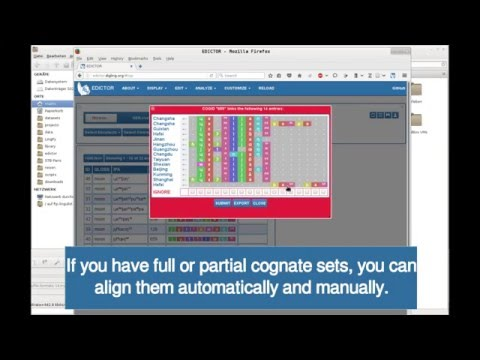

In [23]:
from IPython.display import YouTubeVideo
YouTubeVideo('IyZuf6SmQM4')

### Evaluation with LingPy

LingPy has a couple of evaluation methods implemented, and since we have original expert cognate judgments from ABVD, we can compare our findings against theirs. Comparing cognate set accuracy is not necessarily a trivial problem, as we deal with cluster comparisons, which is a topic that was debated a lot in circles outside of linguistics, and it would lead us too far away if we discussed it in detail here now. For a linguistic viewpoint with a brief working example of our preferred method, the B-Cubed scores (see [Hauer and Kondrak 2011](:ref:Hauer2011), [Bagga and Baldwin 1998](:ref:Bagga1998), and [Amigo et al. 2009](:ref:Amigo2009)), see List, Greenhill, and Gray (2017). What you need to know, however, is that evaluation in NLP circles usually comes along with the concepts of *precision*, *recall*, and *f-score*. Initially, I found them rather difficult to grasp, as historical linguists usually think in terms of false positives and false negatives. In order to understand the idea, one should think that an algorithm for cognate detection can basically do two things either right or wrong: it could cluster words which are not cognate, or it could fail to cluster words as cognate. In the first case, we would measure this in terms of precision, by counting, how often the algorithm proposes correct or incorrect answers, and in the latter case, we measure the proportion of cognate sets which are missed. In the B-Cubed measure we use, this translates roughly to a measure of false/true positives vs. false/true negatives, but it is not entirely the same. The f-score computes the harmonic mean, which summarizes both values, and we usually want to improve the f-score and we use it to compare different algorithms with each other. 

Let's start and do this comparison now, by loading the respective functions from the LingPy evaluation module, and computing precision, recall, and f-scores for all our different automatically inferred cognate sets with respect to the gold standard. The gold standard is located in the column `COGID` of the input file, so we need to name this when comparing with any of the other columns (like `LEXSTATID`, etc., ```$ python3 autocogs.py evaluate``` in terminal).

In [24]:
from lingpy.evaluate.acd import bcubes, diff
wl = Wordlist('east-polynesian-lexstat.tsv')

for res in ['turchinid', 'scaid', 'lexstatid', 'infomap']:
    print('{0:10}\t{1[0]:.2f}\t{1[1]:.2f}\t{1[2]:.2f}'.format(
        res,
        bcubes(wl, 'cogid', res, pprint=False)
    ))

turchinid 	0.95	0.68	0.79
scaid     	0.88	0.82	0.85
lexstatid 	0.95	0.90	0.92
infomap   	0.95	0.91	0.93


You can see, that the "infomap" method is, in fact, working one point better than the normal "lexstat" method, and you can also see how deep the difference between the correspondence-informed methods and the other methods is. As a last way to inspect the data, we will now use the `diff` function to create a file that contrasts the expert cognate sets with the ones inferred by Infomap (```$ python3 autocogs.py diff``` in terminal).

In [25]:
bc, pair, log = diff(wl, 'cogid', 'infomap', tofile=False, pprint=True)
print('\n'.join(log[:15]))

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.9447 *
* Recall:        0.9090 *
* F-Scores:      0.9265 *
*************************'*************************
* Pair   -Scores        *
* --------------------- *
* Precision:     0.9119 *
* Recall:        0.8661 *
* F-Scores:      0.8884 *
*************************'
Concept: above, False Positives: no, False Negatives: yes
Austral_1213     	ɢuʔa  	   1	   1
Hawaiian_52      	i_luna	   1	   1
Mangareva_239    	ruŋa  	   1	   1
Maori_85         	i_ruŋa	   1	   1
NorthMarquesan_38	ʔuna  	   1	   1
Rapanui_264      	ruga  	   1	   1
Tuamotuan_246    	ruŋa  	   1	   1
Austral_128      	nuʔa  	   1	   2
Tahitian_173     	niʔa  	   1	   2
#
Concept: all, False Positives: yes, False Negatives: no
Austral_1213     	ʔatoʔa    	   1	   1
Austral_128      	paːʔaːtoʔa	   1	   1
Maori_85         	katoa     	   1	   1


You see in the output that it contrasts the "cogid" with the "infomap" numbers by putting them with words and languages in two columns.

I assume that the format is more or less self-explaining. Note only one thing: the cognate-ids are always re-computed for each concept set, so you cannot compare them with the ones you find in the text. This is, however, justified, as it helps to compare, since LingPy's `diff` method re-numbers the cognate identifiers for each concept in order to maximally contrast findings by the algorithm and the ones proposed by the experts.

### Exporting Distances and Nexus Files

It is clear that for many of those who consult automatic cognate detection, they use the methods in order to be able to do more with the data afterwards. LingPy so far supports quite a few different ways to write your data to file for further use in other software packages. A complete integration of `Nexus` files which transport all information which might be relevant for BEAST, however, does not exist yet (but will be added at some point sooner than later).

You can nevertheless export to nexus, and what the algorithm exports are your presence-absence patterns extracted from the cognate sets (```$ python3 autocogs.py nexus```):

In [26]:
import io
from lingpy.convert.strings import pap2nex

wl = Wordlist('east-polynesian-lexstat.tsv')
paps = wl.get_paps(ref='infomap', missing='?')
nexus = pap2nex(wl.cols, paps, missing='?')
with io.open('east-polynesian.paps.nex', 'w', encoding='utf8') as fp:
    fp.write(nexus)
print(nexus[:1500])

#NEXUS

BEGIN DATA;
DIMENSIONS ntax=10 NCHAR=822;
FORMAT DATATYPE=STANDARD GAP=- MISSING=? interleave=yes;
MATRIX

Austral_1213      1010001000000010010000011001000000000001?????1?1001000001000001100?0???000000111000010110100010?????0???100000?11???10000101010011101000001000101100??????1000000001???001100001000100101110000010001010100001000000010010010001000?????0000110000001010100000001101000000?1??10011100001000010001100010001000000010010001001100100010010001101100000001?0????0100000010??010000????????0000001110100101000???110000?????1010000010000010000????0001000000100001000100101000100000100000001000010000010101001011000000000010110001000100100000100001010000010000000???????10000000010010000001010000000001000101100000100000100010010100010100011000000000100000010010000001000010100000011100010000010000011000000000010000010000011001000010000100010101011110100000100010001001000001000000101101000001000110?????110010010000011001000010100000000
Austral_128       10001100100100100100000110

You can also calculate distances which would be interesting for packages like SplitsTree (Huson 1998), or also Phylip ([Felsenstein 2005](:ref:Felsenstein2005). For this, you need to be careful, however, since distances can be computed in different ways, and you can choose from a multitude of different distances, and they are not (yet) all documented. The distance calculation as a default counts, how many cognates there are for all concepts between each language pair, so in some way, this tries to mimick Swadesh's original idea of distances or similarities between languages (```$ python3 autocog.py distances``` in commandline):

In [27]:
from lingpy.convert.strings import matrix2dst

dst = matrix2dst(wl.get_distances(ref='infomap', mode='swadesh'), wl.taxa)
with io.open('east-polynesian.dst', 'w', encoding='utf8') as fp:
    fp.write(dst)
print(dst)

2017-09-04 15:07:53,682 [INFO] Successfully calculated dst.


 10
Austral_121 0.00 0.28 0.49 0.46 0.50 0.51 0.52 0.63 0.26 0.46
Austral_128 0.28 0.00 0.40 0.40 0.42 0.46 0.46 0.57 0.15 0.35
Hawaiian_52 0.49 0.40 0.00 0.35 0.40 0.37 0.41 0.51 0.47 0.32
Mangareva_2 0.46 0.40 0.35 0.00 0.35 0.29 0.35 0.43 0.45 0.28
Maori_85   0.50 0.42 0.40 0.35 0.00 0.38 0.41 0.46 0.47 0.33
NorthMarque 0.51 0.46 0.37 0.29 0.38 0.00 0.39 0.43 0.49 0.33
Rapanui_264 0.52 0.46 0.41 0.35 0.41 0.39 0.00 0.43 0.49 0.35
Sikaiana_24 0.63 0.57 0.51 0.43 0.46 0.43 0.43 0.00 0.60 0.37
Tahitian_17 0.26 0.15 0.47 0.45 0.47 0.49 0.49 0.60 0.00 0.40
Tuamotuan_2 0.46 0.35 0.32 0.28 0.33 0.33 0.35 0.37 0.40 0.00



This format follows strictly the Phylip distance format which also cuts off all language names longer than 10 characters (but there are ways to modify this, I can't show them now).

As a final experiment, let us create a tree from the distances, using the simple Neighbor-Joining algorithm, and then print this tree to screen (ignore the warning, ```$ python3 autocogs.py tree```).


In [28]:
from newick import loads
tree = loads(wl.get_tree(ref='infomap', tree_calc='upgma'))[0]

for node in tree.walk():
    if node.name:
        node.name = node.name[1:-1].split('_')[0][:10]
print(tree.ascii_art(show_internal=False))

ImportError: No module named newick

It is not up to me to judge how good this tree is, and it may also be wrongly rooted in the display. But you can see that LingPy can also handle classical tree formats. Although we do not plan to make LingPy a concurrence for tree inference packages, we find it useful to offer Neighbor-joining and UPGMA just to make it easier for users to quickly evaluate their analyses.

## References


* Amigó, E., J. Gonzalo, J. Artiles, and F. Verdejo (2009): A comparison of extrinsic clustering evaluation metrics based on formal constraints. Information Retrieval 12.4. 461-486.
* Bagga, A. and B. Baldwin (1998): Entity-based cross-document coreferencing using the vector space model. In: Proceedings of the 36th Annual Meeting of the Association for Computational Linguistics and 17th International Conference on Computational Linguistics. Association of Computational Linguistics 79-85.
* Bouckaert, R., J. Heled, D. Kühnert, T. Vaughan, C.-H. Wu, D. Xie, M. Suchard, A. Rambaut, and A. Drummond (2014): BEAST 2: A Software Platform for Bayesian Evolutionary Analysis. PLoS Computational Biology 10.4. e1003537.
* Brown, C., E. Holman, and S. Wichmann (2013): Sound correspondences in the world’s languages. Language 89.1. 4-29.
* Cs\’ardi, G. and T. Nepusz (2006): The igraph software package for complex network research. InterJournal. Complex Systems .1695. .
* Dolgopolsky, A. (1964): Gipoteza drevnejšego rodstva jazykovych semej Severnoj Evrazii s verojatnostej točky zrenija [A probabilistic hypothesis concering the oldest relationships among the language families of Northern Eurasia]. Voprosy Jazykoznanija 2. 53-63.
* Downey, S., B. Hallmark, M. Cox, P. Norquest, and S. Lansing (2008): Computational feature-sensitive reconstruction of language relationships: developing the ALINE distance for comparative historical linguistic reconstruction. Journal of Quantitative Linguistics 15.4. 340-369.
* Felsenstein, J. (2005): PHYLIP (Phylogeny Inference Package).
* Greenhill, S., R. Blust, and R. Gray (2008): The Austronesian Basic Vocabulary Database: From bioinformatics to lexomics. Evolutionary Bioinformatics 4. 271-283.
* Hammarström, H., R. Forkel, and M. Haspelmath (2017): Glottolog. Max Planck Institute for Evolutionary Anthropology: Leipzig.
* Hauer, B. and G. Kondrak (2011): Clustering semantically equivalent words into cognate sets in multilingual lists. In: Proceedings of the 5th International Joint Conference on Natural Language Processing. AFNLP 865-873.
* Huson, D. (1998): SplitsTree: analyzing and visualizing evolutionary data. Bioinformatics 14.1. 68-73.
* Levenshtein, V. (1965): Dvoičnye kody s ispravleniem vypadenij, vstavok i zameščenij simvolov [Binary codes with correction of deletions, insertions and replacements]. Doklady Akademij Nauk SSSR 163.4. 845-848.
* List, J.-M. (2012): SCA. Phonetic alignment based on sound classes. In: Slavkovik, M. and D. Lassiter (eds.): New directions in logic, language, and computation. Springer: Berlin and Heidelberg. 32-51.
* List, J.-M. (2012): LexStat. Automatic detection of cognates in multilingual wordlists. In: Proceedings of the EACL 2012 Joint Workshop of Visualization of Linguistic Patterns and Uncovering Language History from Multilingual Resources. 117-125.
* List, J.-M. (2014): Investigating the impact of sample size on cognate detection. Journal of Language Relationship 11. 91-101.
* List, J.-M. (2014): Sequence comparison in historical linguistics. Düsseldorf University Press: Düsseldorf.
* List, J.-M., M. Cysouw, and R. Forkel (2016): Concepticon. A resource for the linking of concept lists. In: Proceedings of the Tenth International Conference on Language Resources and Evaluation. 2393-2400.
* List, J.-M. and R. Forkel (2016): LingPy. A Python library for historical linguistics. Max Planck Institute for the Science of Human History: Jena.
* List, J.-M., P. Lopez, and E. Bapteste (2016): Using sequence similarity networks to identify partial cognates in multilingual wordlists. In: Proceedings of the Association of Computational Linguistics 2016 (Volume 2: Short Papers). Association of Computational Linguistics 599-605.
* List, J.-M., S. Greenhill, and R. Gray (2017): The potential of automatic word comparison for historical linguistics. PLOS ONE 12.1. 1-18.
* List, J.-M. (2017): A web-based interactive tool for creating, inspecting, editing, and publishing etymological datasets. In: Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics. System Demonstrations. 9-12.
* Moran, S. and M. Cysouw (2017): The Unicode Cookbook for Linguists: Managing writing systems using orthography profiles. Zenodo: Zürich.
* Notredame, C., D. Higgins, and J. Heringa (2000): T-Coffee. A novel method for fast and accurate multiple sequence alignment. Journal of Molecular Biology 302. 205-217.
* Rosvall, M. and C. Bergstrom (2008): Maps of random walks on complex networks reveal community structure. Proceedings of the National Academy of Sciences 105.4. 1118-1123.
* Saitou, N. and M. Nei (1987): The neighbor-joining method: A new method for reconstructing phylogenetic trees. Molecular Biology and Evolution 4.4. 406-425.
* Sokal, R. and C. Michener (1958): A statistical method for evaluating systematic relationships. University of Kansas Scientific Bulletin 28. 1409-1438.
* Turchin, P., I. Peiros, and M. Gell-Mann (2010): Analyzing genetic connections between languages by matching consonant classes. Journal of Language Relationship 3. 117-126.


